# Amazon Fine Food Reviews Analysis
(For Refrence Purpose)

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import string

# Importing Natural Language Processing Tool-Kit for processing Text
import nltk
from nltk.stem.porter import PorterStemmer

# Importing from sckit-learn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc


In [3]:
# creating connection in sqlite to fetch data or perform operation on database
con = sqlite3.connect('database.sqlite')

#Filtering only +ve and -ve reviews ie not taking score = 3 and creating dataframe
filtered_data = pd.read_sql_query('''
SELECT * FROM Reviews WHERE Score !=3
''',con)

#given reviews <3 are considered to be -ve and >3 are +ve
def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

# changing column score with string positive and negative
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Exploratory Data Analytics
## Data Cleaning : Deduplication
#### 20 to 30 percentage time is spend in Data cleaning and Data Preprocessing
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:


In [0]:
# Sorting data according to ProductId in ascending order
# Parameter:
# (string:on which it is sort by , 
# axis: 0 means row-wise and 1 means column-wise,
# ascending: True or False,
# inplace : if True perform operation inplace ie. on original value,
# kind=quicksort(default): types of sorting algo {MergeSort,QuickSort,HeapSort},applied when sorting single column,
# na_position=last : first puts NaNs at the beginning, last puts NaNs at the end)

sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True, inplace=False, kind='quicksort', na_position='last')

In [149]:
# Deduplication of entries : removing duplicate entries
# keep = 'first' means keepiing the 1st entry other will removed
# Parameter:
# (subset=all-columns : consider only cetrain columns for identifying duplicates ,
# keep : 'first' keep 1st and remove remaining 'last' keep last only 'False' remove all duplicates ,
# inplace = drop duplicate inplace or retturn copy)

final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
print("Including Duplicates =",filtered_data.shape)
print("Removing Duplicates =",final.shape)
# 30% of data was duplicate

Including Duplicates = (525814, 10)
Removing Duplicates = (364173, 10)


In [150]:
display = pd.read_sql_query('''
SELECT * FROM Reviews
WHERE Score !=3 AND HelpfulnessNumerator > HelpfulnessDenominator
ORDER BY ProductID
''',con)

display[:5:]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

### Its Important to know the classification distribution

In [152]:
print(final.shape)
# It return the count of each value
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Bag of Words (BoW)

In [0]:
count_vector = CountVectorizer() # in sckit-Learn
# converting text into values or vectors
final_counts = count_vector.fit_transform(final['Text'].values)

In [155]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [156]:
final_counts.shape

(364171, 115281)

# Text Preprocessing : Stemming, stop-word removal and Lematization
    1.Using snowball stemming bcz more powerful than Porter Stemming

In [157]:
print(final['Text'].head(7))

138706    this witty little book makes my son laugh at l...
138688    I grew up reading these Sendak books, and watc...
138689    This is a fun way for children to learn their ...
138690    This is a great little book to read aloud- it ...
138691    This is a book of poetry about the months of t...
138693    A charming, rhyming book that describes the ci...
138694    I set aside at least an hour each day to read ...
Name: Text, dtype: object


In [158]:
# module re = regular expression
import re
# find sentenses containing HTML Tags
i=0;
for sent in final['Text'].values:
    # using regular expression to search  html tags
    if (len(re.findall('<.*?>',sent))):
        print(i)
        print(sent)
        break
    i+=1
print()

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.



In [159]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) # set of stopwords
sno = nltk.stem.SnowballStemmer('english') # initialize snowball stemmer

def cleanhtml(sentence): # removes html tags in data
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence): #clean the word of any punchuation
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

print("Stopwords")
print(stop)
print("*******************")
print(sno.stem('tasty'))
print(final.shape)

Stopwords
{'what', 'he', 'your', 'until', 'to', 'before', 'ourselves', 'the', 'be', 'themselves', 'being', 'off', 've', 'himself', "should've", 'd', 'once', 'about', 'again', 'needn', 'won', 'with', 'shouldn', 'of', 'these', 'only', 'own', 'same', 'hadn', 'isn', "couldn't", 'between', 'after', 'such', "she's", 'doesn', 'y', 'under', 'itself', 'have', 'does', "mightn't", 'am', 'against', 'hers', 'weren', 'shan', 'or', "needn't", 'both', 'an', 'how', 'now', 'ain', 'didn', "weren't", 'm', 'herself', "that'll", 'those', 'just', "you've", 'who', 'do', "wasn't", 'other', "you're", 'very', "don't", 'should', 'there', 'my', 'at', 'she', 'it', 'will', 'into', 'yourselves', 'yours', 'but', 'were', 'ma', 'is', 'had', 'because', 'its', 'above', 'that', "aren't", 'myself', 'further', 're', 'and', 'some', 'here', 'him', 's', 'doing', "it's", 'mightn', 'in', 'through', 'we', 'a', 'any', 'from', 'on', 'up', 'too', "shouldn't", 'was', 'his', 'having', 'yourself', 'while', 'when', 'more', "didn't", 'bel

In [2]:
# Creting list of text data after preprocessing
# REDUCING DATA POINTS FOR COMPUTATION ON LOCAL MACHINE
# final = final[:10000]
print(final.shape)
i=0
str1=''
final_string=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if cleaned_words.isalpha() and len(cleaned_words)>2:
                if cleaned_words.lower() not in stop:
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                  continue
            else:
              continue
    # here b specifies that the string is 8-bits or 1 byte which is UTF-8
    str1=b" ".join(filtered_sentence)
    final_string.append(str1)
    i+=1
print('*'*25)


(364171, 10)
*************************


# Saving the data after computation into database 
## Due to computation limitation

In [166]:
final['CleanedText'] = final_string # add a column of CleanedText 
print((final['CleanedText']).head())

138706    b'witti littl book make son laugh loud recit c...
138688    b'grew read sendak book watch realli rosi movi...
138689    b'fun way children learn month year learn poem...
138690    b'great littl book read nice rhythm well good ...
138691    b'book poetri month year goe month cute littl ...
Name: CleanedText, dtype: object


In [0]:
# store final table into sqllite table for reusing do not need to performed computation again.
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
final.to_sql('Reviews',conn,schema = None, if_exists='replace')

# Reusing the saved data

In [30]:
# creating connection in sqlite to fetch data or perform operation on database
con = sqlite3.connect('final.sqlite')

#Filtering only +ve and -ve reviews ie not taking score = 3 and creating dataframe
final = pd.read_sql_query('''
SELECT * FROM Reviews
''',con)

print(final.shape)
final.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


# Applying Bag of Words(BoW) on Cleaned Text column of table

In [31]:
print(final['CleanedText'].head())
print(final.keys())

0    b'witti littl book make son laugh loud recit c...
1    b'grew read sendak book watch realli rosi movi...
2    b'fun way children learn month year learn poem...
3    b'great littl book read nice rhythm well good ...
4    b'book poetri month year goe month cute littl ...
Name: CleanedText, dtype: object
Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')


In [48]:
count_vector = CountVectorizer() # in sckit-Learn
# converting text into values or vectors

final = final[:1000]

final_counts = count_vector.fit_transform(final['CleanedText'].values)
print(final_counts.shape)

(1000, 4703)


In [36]:
print(type(final_counts))
print(final_counts.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(1000, 4703)


# Applying t-SNE algorithm to plot the vectors of cleaned text

(1000, 2)


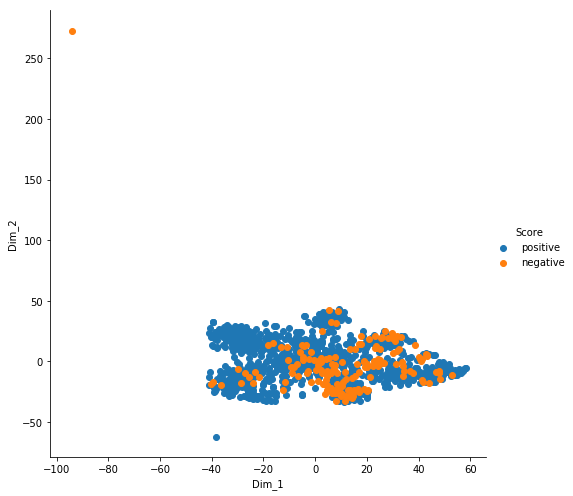

In [49]:
from sklearn.manifold import TSNE

# configuring the parameters
# the number of components = 2 
# default perplexity = 30
# default learning rate (epsilon) = 200
# default Maximum number of steps or iteration = 1000
# random_state is the no. which define that algo generate same results on multiple run bcs t-SNE is randomize algo
model = TSNE(n_components=2, random_state = 0,perplexity=10,n_iter=5000)

# generate the t-SNE data from above model used from sklearn and by passing data
tsne_data = model.fit_transform(final_counts.toarray())

print(tsne_data.shape)

# creating a new data frame which has column of Score so that we can classfy tha data points
tsne_data = np.vstack((tsne_data.T,final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data,columns=("Dim_1","Dim_2","Score"))

# plotting the result of tsne
sb.FacetGrid(tsne_df,hue="Score",height=7).map(plt.scatter,"Dim_1","Dim_2").add_legend()
plt.show()